devoloping PCA algorithm for dimension reduction

Loading cached PCA results from cache/pca_2_components.pkl...


Loading PCA results: 100%|██████████| 1/1 [00:00<00:00, 199.07file/s]
/tmp/ipykernel_60677/1843221352.py:161: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('rainbow', len(unique_labels))  # 'tab20' supports up to 20 colors, cycles if needed
/tmp/ipykernel_60677/1843221352.py:171: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


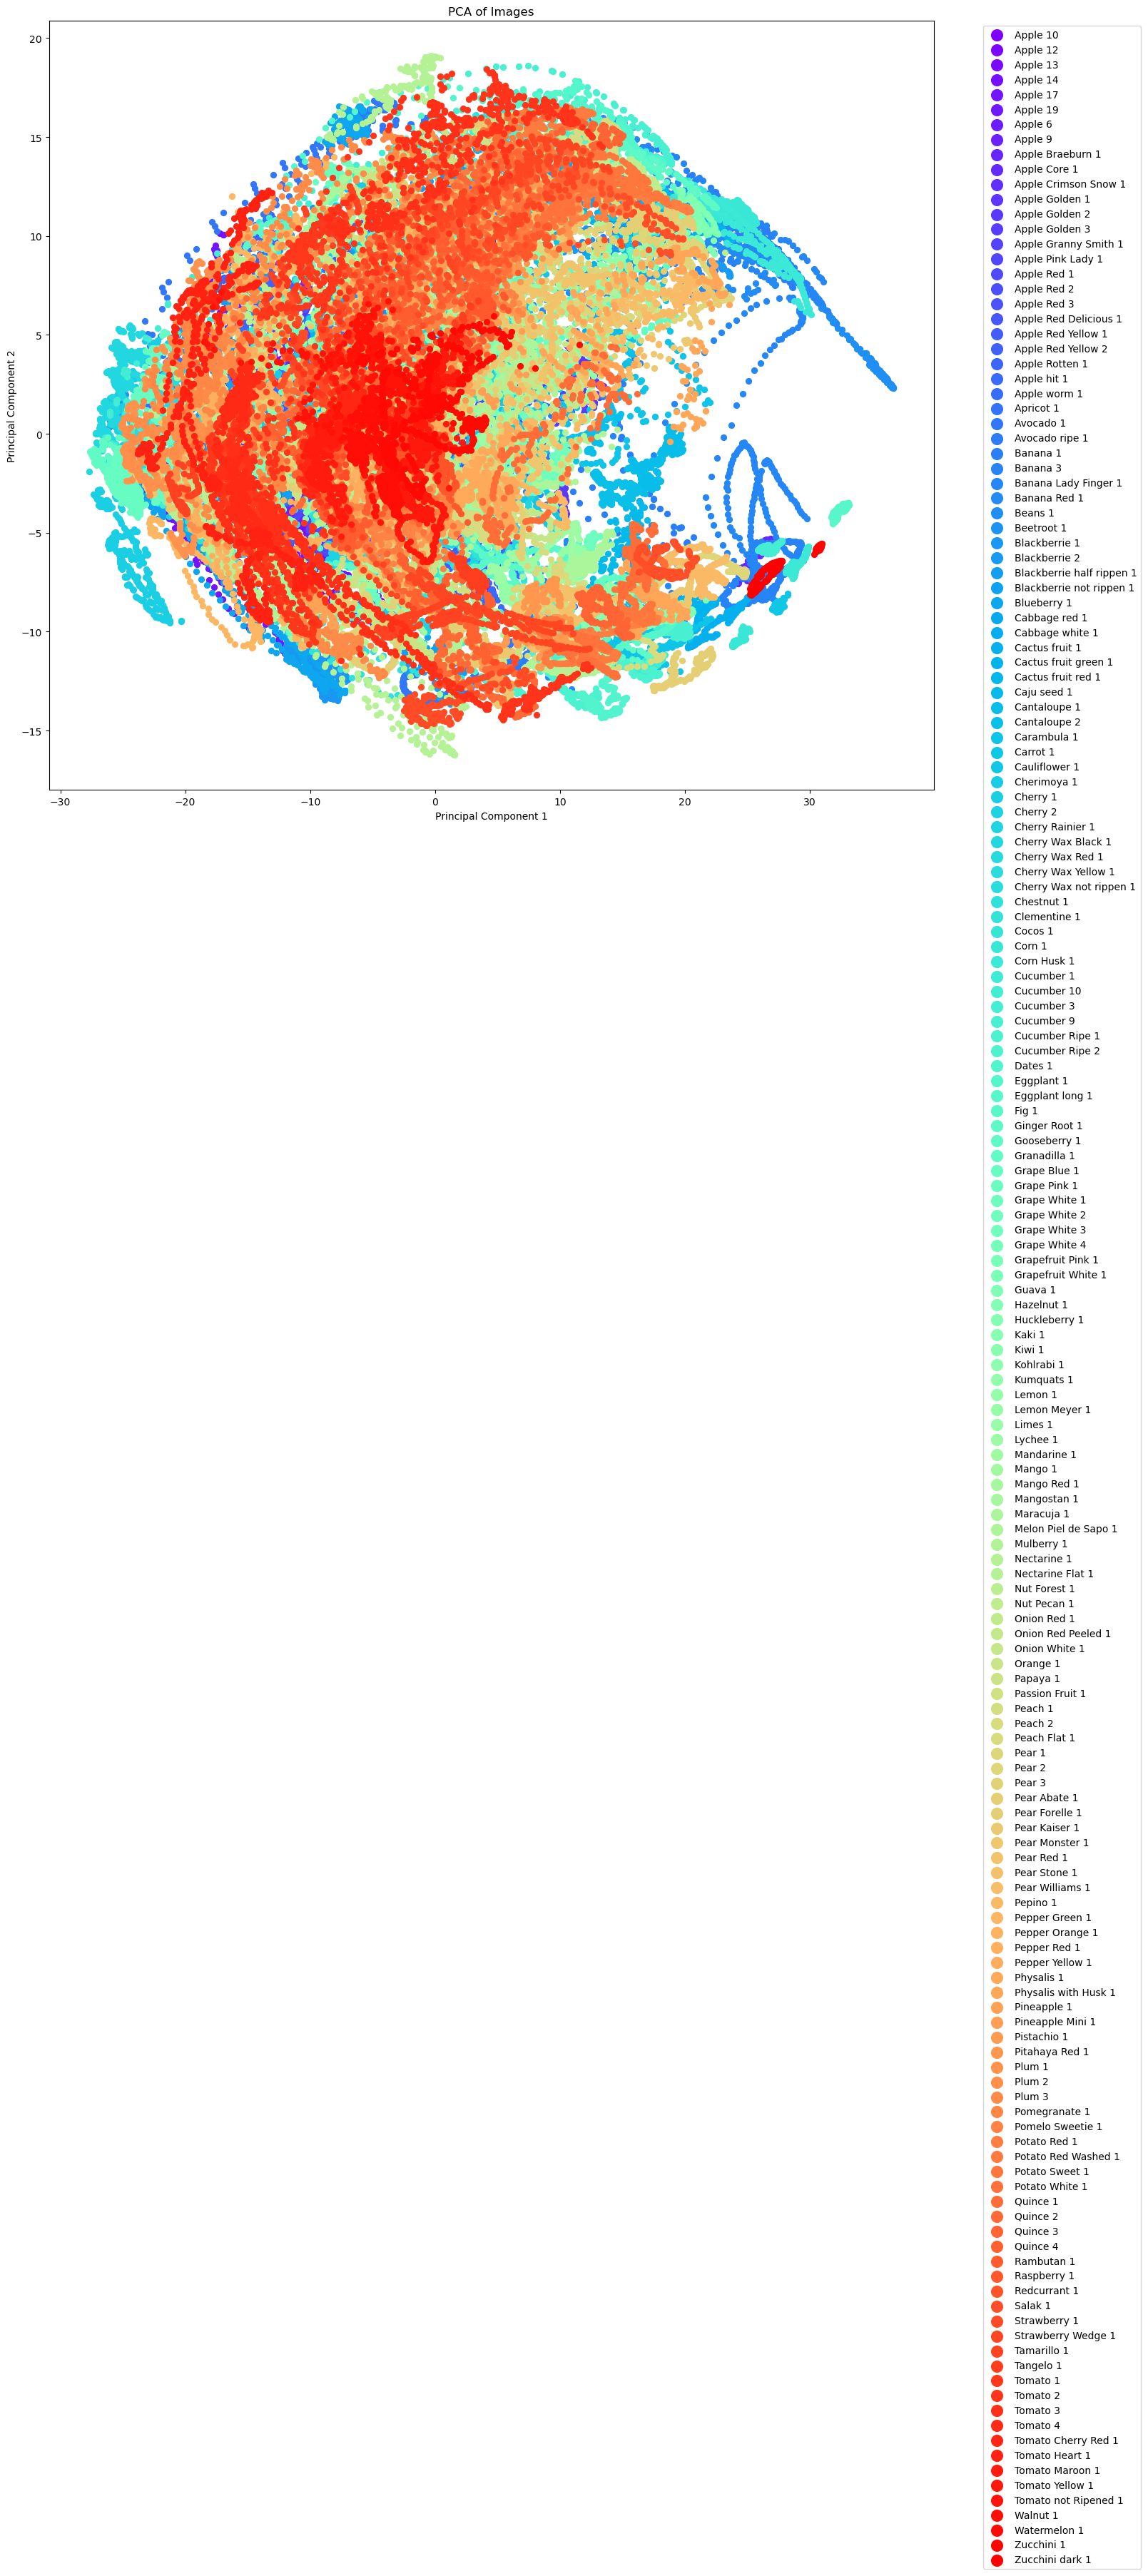

In [1]:
# Import necessary libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import IncrementalPCA
from os.path import isfile, join
import os
import pickle  # For saving/loading processed data
from tqdm import tqdm  # For progress bars

# Define a directory to store cached data
CACHE_DIR = "cache"
os.makedirs(CACHE_DIR, exist_ok=True)  # Ensure the cache directory exists

# Function to import images in batches
def import_images_in_batches(path, resize_dim=(50, 50), batch_size=1000):
    """
    Imports images from the specified directory in batches. If a cache file exists, 
    it loads the cached data instead of reprocessing the images.

    Args:
        path (str): Path to the directory containing image folders.
        resize_dim (tuple): Dimensions to resize the images (default: 50x50).
        batch_size (int): Number of images to process in each batch.

    Yields:
        tuple: A batch of images and their corresponding labels.
    """
    # Define the cache file name based on the resize dimensions
    cache_file = join(CACHE_DIR, f"images_{resize_dim[0]}x{resize_dim[1]}.pkl")
    
    # Check if the cache file exists
    if isfile(cache_file):
        try:
            print(f"Loading cached images from {cache_file}...")
            # Load cached images and labels with a progress bar
            with tqdm(total=1, desc="Loading cached images", unit="file") as pbar:
                with open(cache_file, "rb") as f:
                    images, labels = pickle.load(f)
                pbar.update(1)
        except (EOFError, pickle.UnpicklingError):
            # Handle corrupted cache files
            print(f"Corrupted cache file detected: {cache_file}. Deleting it...")
            os.remove(cache_file)
            raise RuntimeError("Cache file was corrupted and has been deleted. Please rerun the script.")
        
        # Yield batches of images and labels
        for i in range(0, len(images), batch_size):
            yield images[i:i + batch_size], labels[i:i + batch_size]
    else:
        # Process images if no cache file exists
        print("Processing images...")
        images = []
        labels = []
        folders = os.listdir(path)  # List all folders in the directory
        
        # Iterate through each folder
        for folder in tqdm(folders, desc="Importing images", unit="folder"):
            folder_path = join(path, folder)
            if os.path.isdir(folder_path):  # Check if it's a directory
                files = os.listdir(folder_path)
                
                # Iterate through each file in the folder
                for file in tqdm(files, desc=f"Processing {folder}", leave=False, unit="file"):
                    file_path = join(folder_path, file)
                    if isfile(file_path):  # Check if it's a file
                        img = cv2.imread(file_path)  # Read the image
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                        img = cv2.resize(img, resize_dim)  # Resize the image
                        images.append(img.flatten())  # Flatten the image
                        labels.append(folder)  # Use the folder name as the label
        
        # Normalize pixel values and convert to NumPy arrays
        images = np.array(images, dtype=np.float32) / 255.0
        labels = np.array(labels)
        
        # Save the processed images and labels to the cache file
        print(f"Saving processed images to {cache_file}...")
        with tqdm(total=1, desc="Saving images", unit="file") as pbar:
            with open(cache_file, "wb") as f:
                pickle.dump((images, labels), f)
            pbar.update(1)
        
        # Yield batches of images and labels
        for i in range(0, len(images), batch_size):
            yield images[i:i + batch_size], labels[i:i + batch_size]

# Function to apply Incremental PCA
def apply_incremental_pca(path, n_components, resize_dim=(50, 50), batch_size=1000):
    """
    Applies Incremental PCA to reduce the dimensionality of the images. If a cache file exists,
    it loads the cached PCA results instead of recomputing them.

    Args:
        path (str): Path to the directory containing image folders.
        n_components (int): Number of principal components to retain (default: 2).
        resize_dim (tuple): Dimensions to resize the images (default: 50x50).
        batch_size (int): Number of images to process in each batch.

    Returns:
        tuple: Reduced images and their corresponding labels.
    """
    # Define the cache file name based on the number of components
    cache_file = join(CACHE_DIR, f"pca_{n_components}_components.pkl")
    
    # Check if the cache file exists
    if isfile(cache_file):
        print(f"Loading cached PCA results from {cache_file}...")
        # Load cached PCA results with a progress bar
        with tqdm(total=1, desc="Loading PCA results", unit="file") as pbar:
            with open(cache_file, "rb") as f:
                reduced_images, labels = pickle.load(f)
            pbar.update(1)
    else:
        # Perform Incremental PCA if no cache file exists
        print("Fitting Incremental PCA...")
        ipca = IncrementalPCA(n_components=n_components)
        labels = []
        reduced_images = []
        batches = list(import_images_in_batches(path, resize_dim, batch_size))
        
        # Fit PCA in batches
        with tqdm(total=len(batches), desc="Fitting PCA batches", unit="batch") as pbar:
            for images_batch, labels_batch in batches:
                ipca.partial_fit(images_batch)
                labels.extend(labels_batch)
                pbar.update(1)
        
        # Transform data in batches
        print("Transforming data with Incremental PCA...")
        with tqdm(total=len(batches), desc="Transforming PCA batches", unit="batch") as pbar:
            for images_batch, _ in batches:
                reduced_images.append(ipca.transform(images_batch))
                pbar.update(1)
        
        # Combine transformed batches and save to cache
        reduced_images = np.vstack(reduced_images)
        labels = np.array(labels)
        print(f"Saving PCA results to {cache_file}...")
        with tqdm(total=1, desc="Saving PCA results", unit="file") as pbar:
            with open(cache_file, "wb") as f:
                pickle.dump((reduced_images, labels), f)
            pbar.update(1)
    
    return reduced_images, labels

# Function to visualize PCA results
def visualize_pca(reduced_images, labels):
    """
    Visualizes the PCA results in a 2D scatter plot.

    Args:
        reduced_images (np.ndarray): PCA-reduced images.
        labels (np.ndarray): Corresponding labels for the images.
    """
    plt.figure(figsize=(16, 14))
    unique_labels = np.unique(labels)
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    numeric_labels = np.array([label_to_index[label] for label in labels])
    
    colormap = plt.cm.get_cmap('rainbow', len(unique_labels))  # 'tab20' supports up to 20 colors, cycles if needed
    # Plot each label as a scatter plot
    for i, label in enumerate(unique_labels):
        mask = numeric_labels == i
        plt.scatter(reduced_images[mask, 0], reduced_images[mask, 1], label=label,s = 32, color=colormap(i / len(unique_labels)))
    
    plt.title('PCA of Images')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Main function to execute the script
def main():
    """
    Main function to execute the PCA pipeline: importing images, applying PCA, and visualizing results.
    """
    path = 'fruits-360/Training'  # Path to the dataset
    if not os.path.exists(path):
        print(f"Error: Path '{path}' does not exist.")
        return
    
    # Apply Incremental PCA and visualize the results
    reduced_images, labels = apply_incremental_pca(path, n_components=2, resize_dim=(50, 50), batch_size=1000)
    visualize_pca(reduced_images, labels)

# Entry point of the script
if __name__ == "__main__":
    main()

Loading cached PCA results from cache/pca_3_components.pkl...


Loading PCA results: 100%|██████████| 1/1 [00:00<00:00, 145.75file/s]
/tmp/ipykernel_60677/3627982233.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('rainbow', len(unique_labels))
/tmp/ipykernel_60677/3627982233.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


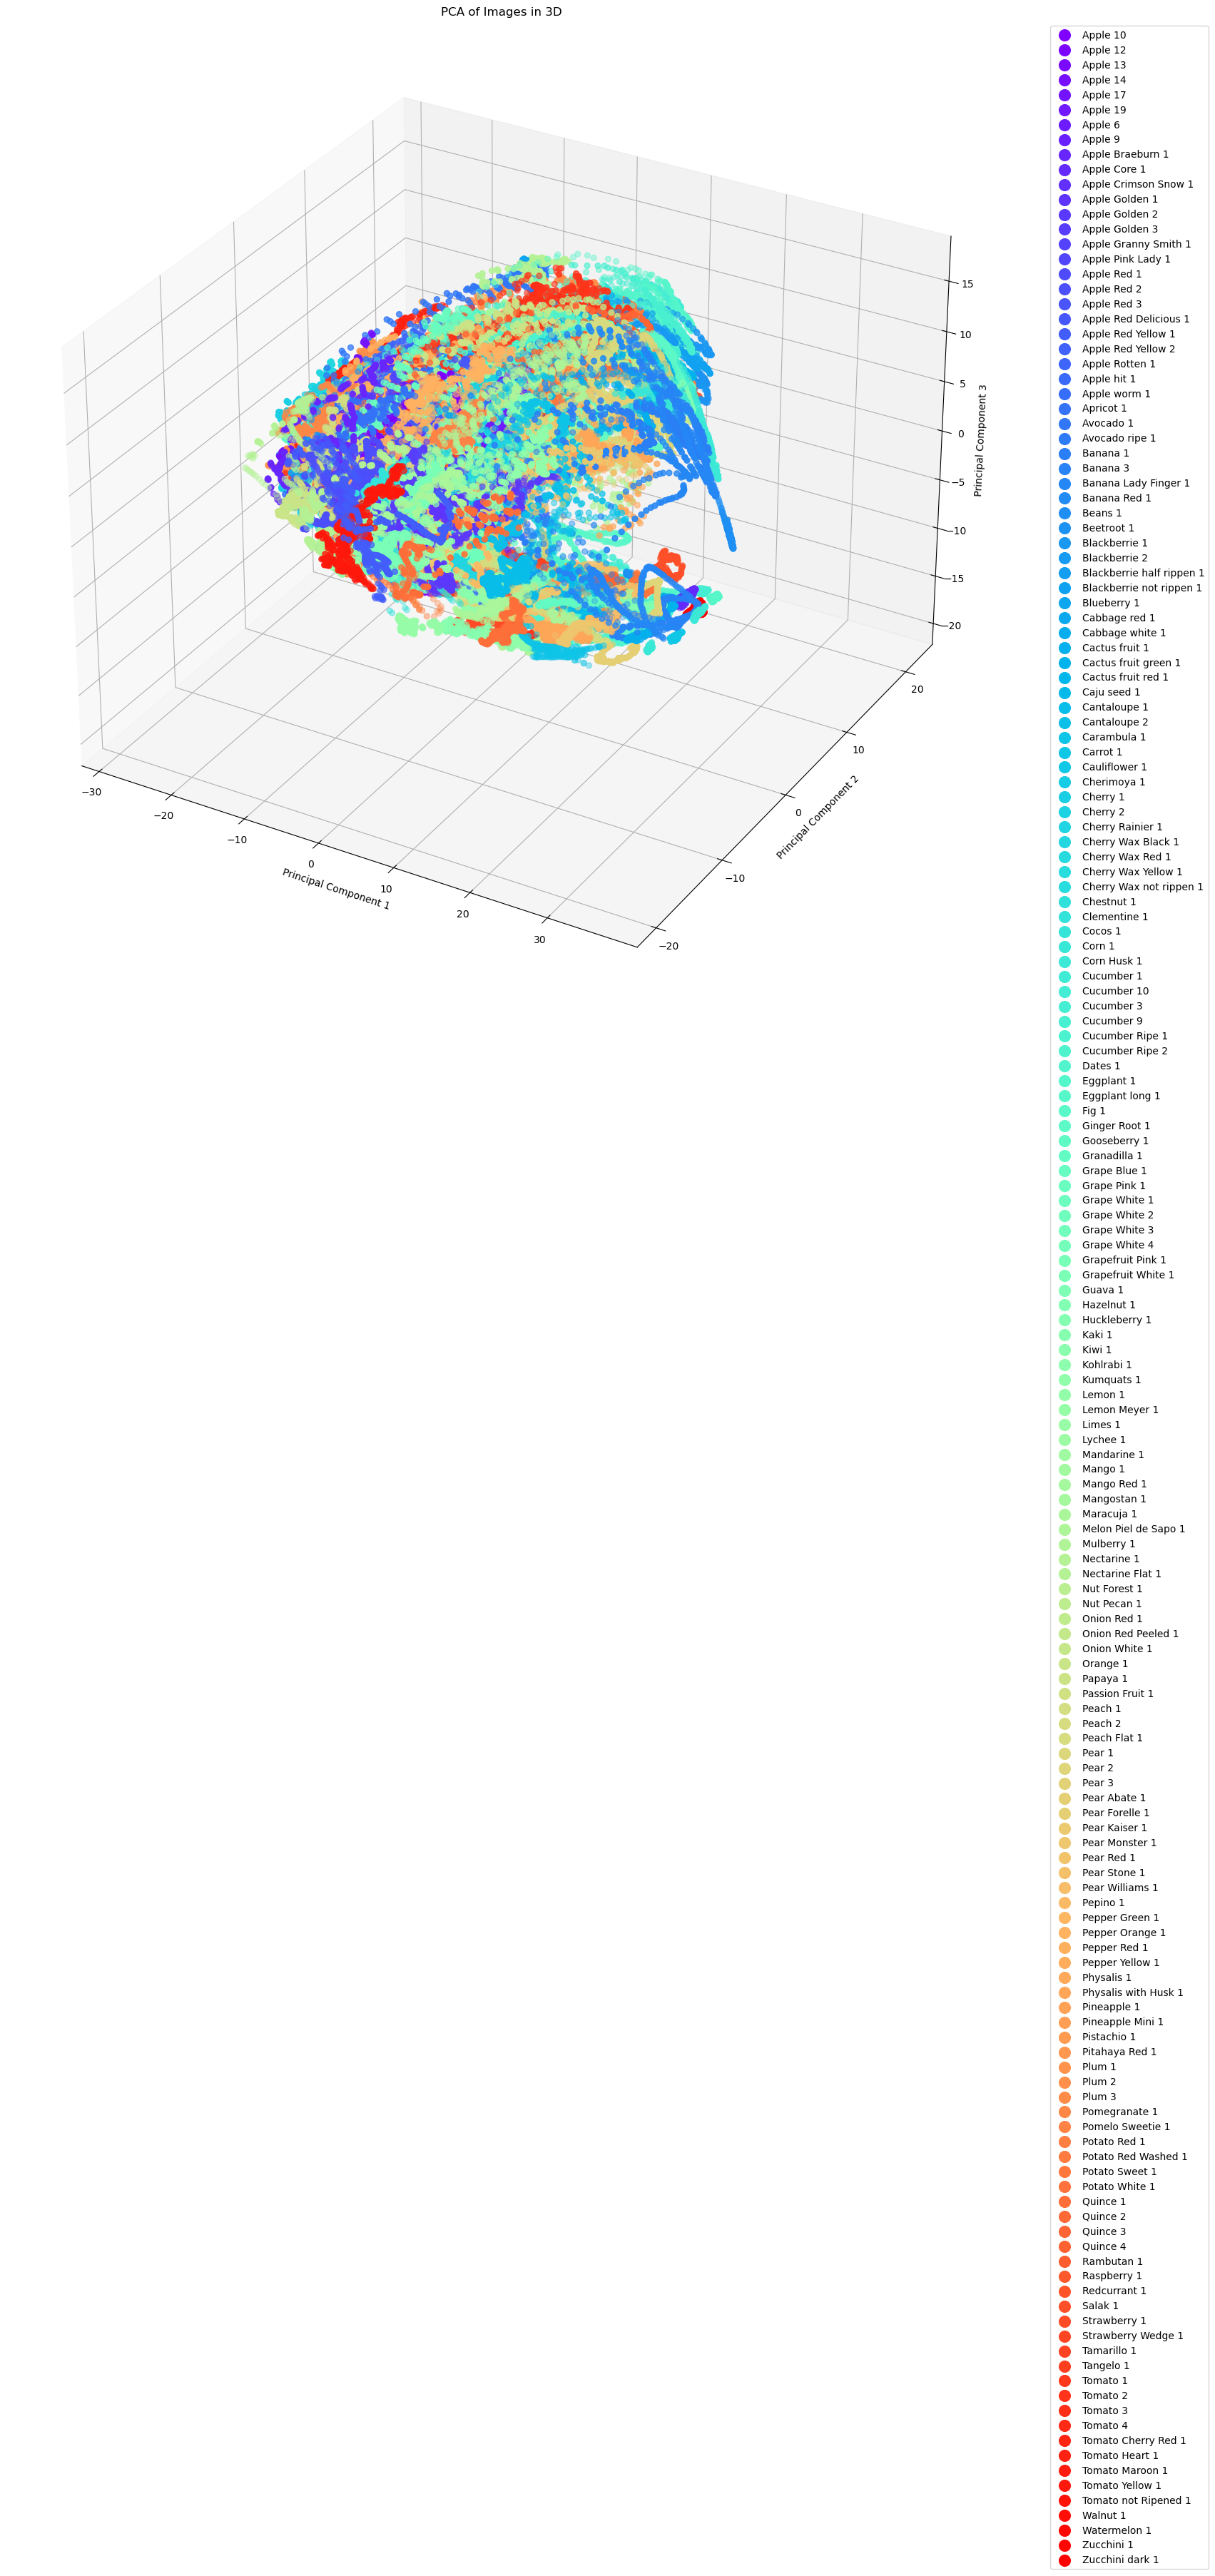

In [8]:
# this code will do PCA on images like code above and with n_components = 3 
# and visualize the results in 3D
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting
from matplotlib.widgets import Button  # For adding interactive buttons
def visualize_pca_3d(reduced_images, labels):
    """
    Visualizes the PCA results in a 3D scatter plot.

    Args:
        reduced_images (np.ndarray): PCA-reduced images.
        labels (np.ndarray): Corresponding labels for the images.
    """
    
    fig = plt.figure(figsize=(20, 18))
    ax = fig.add_subplot(111, projection='3d')
    unique_labels = np.unique(labels)
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    numeric_labels = np.array([label_to_index[label] for label in labels])
    
    colormap = plt.cm.get_cmap('rainbow', len(unique_labels))
    for i, label in enumerate(unique_labels):
        mask = numeric_labels == i
        ax.scatter(reduced_images[mask, 0], reduced_images[mask, 1], reduced_images[mask, 2], label=label, s=32, color=colormap(i / len(unique_labels)))
    
    ax.set_title('PCA of Images in 3D')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Enable interactive rotation and zoom
    plt.tight_layout()
    plt.ion()  # Turn on interactive mode
# Main function to execute the script   
def main_3d():
    """
    Main function to execute the PCA pipeline: importing images, applying PCA, and visualizing results in 3D.
    """
    path = 'fruits-360/Training'  # Path to the dataset
    if not os.path.exists(path):
        print(f"Error: Path '{path}' does not exist.")
        return
    
    # Apply Incremental PCA and visualize the results
    reduced_images, labels = apply_incremental_pca(path, n_components=3, resize_dim=(50, 50), batch_size=1000)
    visualize_pca_3d(reduced_images, labels)
# Entry point of the script
if __name__ == "__main__":
    main_3d()


Loading cached PCA results from cache/pca_3_components.pkl...


Loading PCA results: 100%|██████████| 1/1 [00:00<00:00, 274.44file/s]

Applying KMeans with 136 clusters...


KMeans clustering completed.
Visualizing KMeans clustering results in 3D...


/tmp/ipykernel_60677/761288875.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('rainbow', len(unique_labels))


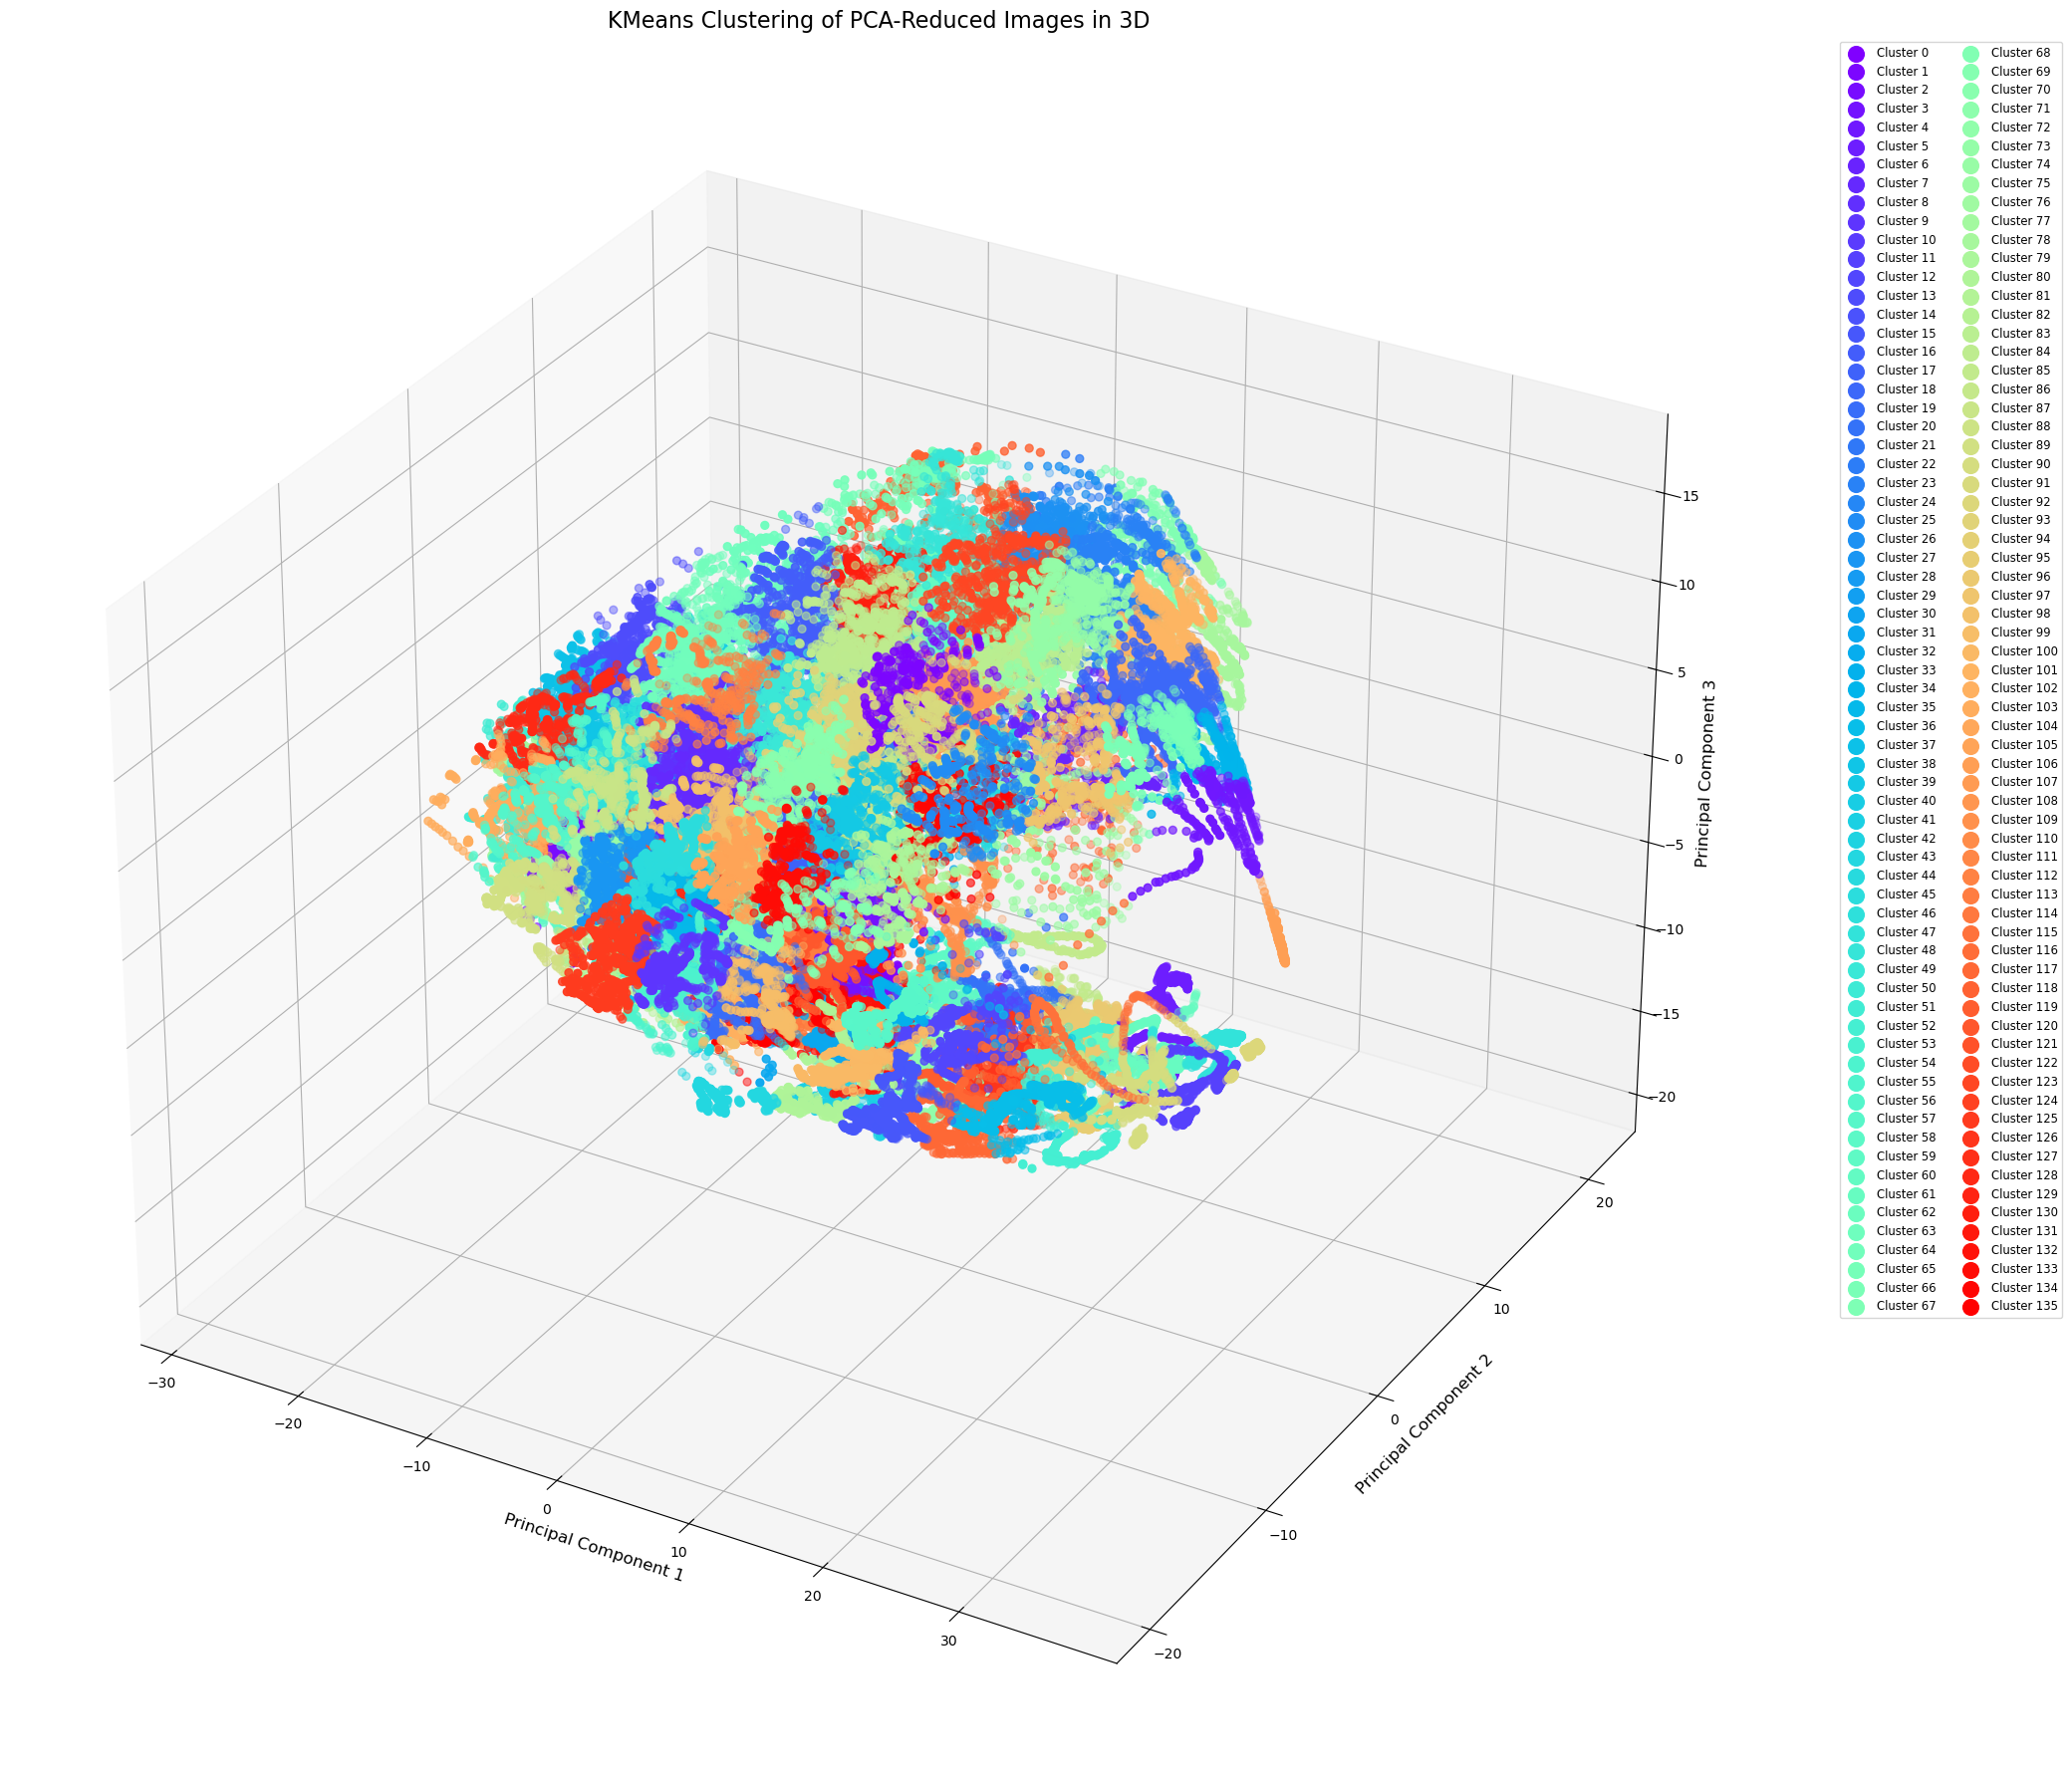

Visualization completed.


In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import os

def apply_kmeans(reduced_images, n_clusters=136):
    """
    Applies KMeans clustering to the PCA-reduced images.

    Args:
        reduced_images (np.ndarray): PCA-reduced images.
        n_clusters (int): Number of clusters for KMeans.

    Returns:
        np.ndarray: Cluster labels for each data point.
    """
    print(f"Applying KMeans with {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)  # Initialize KMeans
    cluster_labels = kmeans.fit_predict(reduced_images)  # Fit and predict cluster labels
    print("KMeans clustering completed.")
    return cluster_labels


def visualize_kmeans_3d(reduced_images, cluster_labels):
    """
    Visualizes the KMeans clustering results in a 3D scatter plot.

    Args:
        reduced_images (np.ndarray): PCA-reduced images.
        cluster_labels (np.ndarray): Cluster labels for each data point.
    """
    print("Visualizing KMeans clustering results in 3D...")
    fig = plt.figure(figsize=(20, 18))
    ax = fig.add_subplot(111, projection='3d')
    
    # Get unique cluster labels and assign colors
    unique_labels = np.unique(cluster_labels)
    colormap = plt.cm.get_cmap('rainbow', len(unique_labels))
    
    # Plot each cluster in the 3D scatter plot
    for i, label in enumerate(unique_labels):
        mask = cluster_labels == label
        ax.scatter(
            reduced_images[mask, 0], 
            reduced_images[mask, 1], 
            reduced_images[mask, 2], 
            label=f'Cluster {label}', 
            s=32, 
            color=colormap(i / len(unique_labels))
        )
    
    # Set plot titles and labels
    ax.set_title('KMeans Clustering of PCA-Reduced Images in 3D', fontsize=16)
    ax.set_xlabel('Principal Component 1', fontsize=12)
    ax.set_ylabel('Principal Component 2', fontsize=12)
    ax.set_zlabel('Principal Component 3', fontsize=12)
    
    # Add legend
    ax.legend(
        markerscale=2, 
        bbox_to_anchor=(1.05, 1), 
        loc='upper left', 
        fontsize='small', 
        ncol=2  # Split legend into 2 columns for better readability
    )
    
    plt.tight_layout()
    plt.show()
    print("Visualization completed.")


# Main function for KMeans
def main_kmeans():
    """
    Main function to execute the PCA pipeline and apply KMeans clustering.
    """
    # Define the path to the dataset
    path = 'fruits-360/Training'
    if not os.path.exists(path):
        print(f"Error: Path '{path}' does not exist.")
        return
    
    # Apply Incremental PCA to reduce dimensionality
    reduced_images, labels = apply_incremental_pca(
        path=path, 
        n_components=3,  # Use 3 components for 3D visualization
        resize_dim=(50, 50), 
        batch_size=1000
    )
    
    # Apply KMeans clustering
    cluster_labels = apply_kmeans(reduced_images, n_clusters=136)  # Adjust the number of clusters as needed
    
    # Visualize the KMeans clustering results
    visualize_kmeans_3d(reduced_images, cluster_labels)


# Entry point of the script
if __name__ == "__main__":
    main_kmeans()